In [1]:
import torch 
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from kmeans_pytorch import kmeans, kmeans_predict
from numpy.lib.stride_tricks import sliding_window_view
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [2]:
class Encoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.window_size = 120

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(self.window_size * 10, self.window_size//2 * 10),
            torch.nn.ReLU(),
            torch.nn.Linear(self.window_size//2 * 10, self.window_size//4 * 10),
            torch.nn.ReLU(),
            torch.nn.Linear(self.window_size//4 * 10, self.window_size//8 * 10),
            torch.nn.ReLU()
        )

 
    def forward(self, x):
        encoded = self.encoder(x)
        return encoded



class Decoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.window_size = 120


        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(self.window_size//8 * 10, self.window_size//4 * 10),
            torch.nn.ReLU(),
            torch.nn.Linear(self.window_size//4 * 10, self.window_size//2 * 10),
            torch.nn.ReLU(),
            torch.nn.Linear(self.window_size//2 * 10, self.window_size * 10),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        decoded = self.decoder(x)
        return decoded



In [3]:
x = np.load("Dane/Learning_data/data/train_df_23_w120.npy")
data = torch.from_numpy(x )
data = data.to(torch.float32).to(device)

In [4]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)


loss_function = torch.nn.MSELoss()
 
# Using an Adam Optimizer with lr = 0.1
optimizer_encoder = torch.optim.Adam(encoder.parameters(),
                             lr = 1e-1,
                             weight_decay = 1e-8)

optimizer_decoder = torch.optim.Adam(decoder.parameters(),
                             lr = 1e-1,
                             weight_decay = 1e-8)


100%|██████████| 20/20 [25:38<00:00, 76.93s/it]


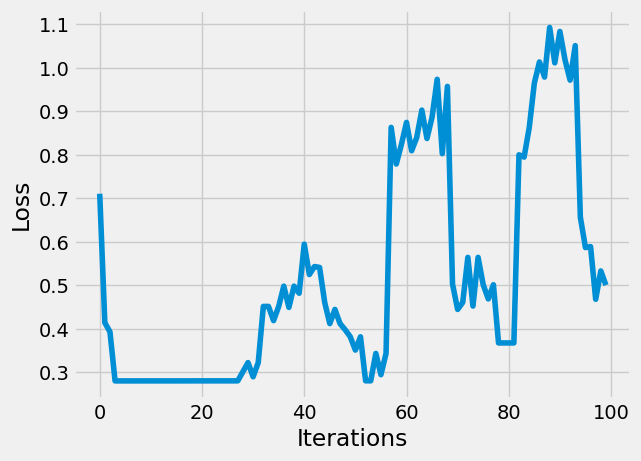

In [5]:


epochs = 20
outputs = []
losses = []
tbar = tqdm(range(epochs))
for epoch in tbar:
    for sample in data:
       
      sample_flatten = sample.flatten()
      # Output of Autoencoder
      # sample = sample.reshape(-1, 10, 120)
      latent_space = encoder(sample_flatten)
      reconstructed = decoder(latent_space)

       
      # Calculating the loss function
      loss = loss_function(reconstructed, sample_flatten)
       
      # The gradients are set to zero,
      # the gradient is computed and stored.
      # .step() performs parameter update
      optimizer_decoder.zero_grad()
      optimizer_encoder.zero_grad()

      loss.backward()
      optimizer_decoder.step()
      optimizer_encoder.step()

       
      # Storing the losses in a list for plotting
      losses.append(loss.to("cpu").detach().numpy())
    outputs.append((epochs, sample_flatten, reconstructed))
 
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Plotting the last 100 values
plt.plot(losses[-100:])


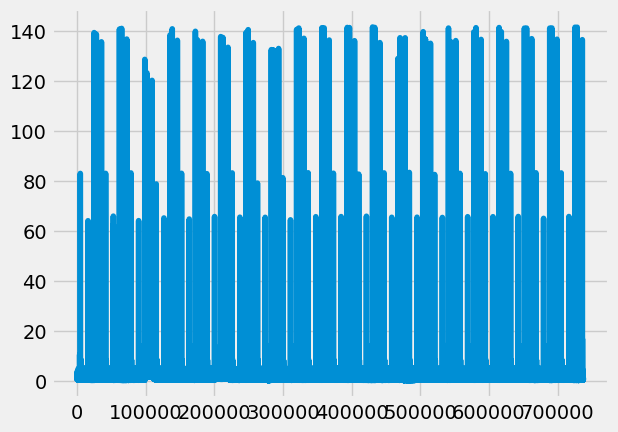

In [9]:
plt.plot(losses)

In [11]:
encoder.eval()
latent_space_eval = []
for sample in data:
    latent_space_eval.append(encoder(sample.flatten()).to("cpu").detach().numpy())

[running kmeans]: 0it [4:23:37, ?it/s]


In [15]:
latent_space_eval = torch.from_numpy(np.array(latent_space_eval))

In [ ]:
# kmeans
cluster_ids_x, cluster_centers = kmeans(
    X=latent_space_eval, num_clusters=5, distance='euclidean', device=torch.device('cuda:0')
)
cluster_ids_x = np.array(cluster_ids_x)

In [ ]:
y = np.random.randn(5, 200) / 6
y = torch.from_numpy(y)

# predict cluster ids for y
cluster_ids_y = kmeans_predict(
    y, cluster_centers, 'euclidean', device=device
)

In [ ]:
plt.figure(figsize=(4, 3), dpi=160)
plt.scatter(x[:, 0,0], x[:, 1,0], c=cluster_ids_x, cmap='cool')
plt.scatter(y[:, 0], y[:, 1], c=cluster_ids_y, cmap='cool', marker='X')
plt.scatter(
    cluster_centers[:, 0], cluster_centers[:, 1],
    c='white',
    alpha=0.6,
    edgecolors='black',
    linewidths=2
)
plt.tight_layout()
plt.show()

In [ ]:
data_test = np.load("Dane/Learning_data/data/train_test.npy")

In [ ]:
data_sliced_train = sliding_window_view(data_test, window_shape=120, axis = 0)

i = 0
j = 0
while j < 10:
    if cluster_ids_x[i] != 3:
        plt.plot(data_sliced_train[i,0,:])
        plt.legend(f"{cluster_ids_x[i]}")
        plt.show()
        j += 1
    i += 1